In [1]:
import numpy as np
import pandas as pd 
from sqlalchemy import create_engine ,cast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# 라이브러리 정의 import tensorflow.keras
import keras
from keras import layers

Using TensorFlow backend.


In [2]:
%matplotlib inline

## 1. 데이터 불러오기

In [54]:
selloutData = pd.read_csv("../dataset/kopo_decision_tree_all_new.csv")
selloutData.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT'],
      dtype='object')

## 2. 지역/상품/아이템별 146개 제품 추출

In [4]:
groupKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM"]

In [5]:
groupData = selloutData.groupby(groupKey)["YEARWEEK"].agg(["size"]).reset_index()

In [6]:
groupData.rename(columns={"size" : "KNOB"}, inplace = True)
groupData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,KNOB
0,A01,PG01,P01,ITEM001,3
1,A01,PG01,P01,ITEM002,2


In [7]:
mergedData = pd.merge(left = selloutData, right = groupData, on = groupKey, how = "left")
mergedData.head(3)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0,3
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0,3
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0,3


In [8]:
maxknob = mergedData.KNOB.max()

In [9]:
refinedData = mergedData[mergedData.KNOB >= maxknob]

In [10]:
sortKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM", "YEARWEEK"]

In [11]:
sortedData = refinedData.sort_values(sortKey).reset_index(drop=True)
sortedData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG02,P03,ITEM043,201501,2015,1,87,Y,1,Y,0.197590,146
1,A01,PG02,P03,ITEM043,201502,2015,2,60,N,4,Y,0.197590,146
2,A01,PG02,P03,ITEM043,201503,2015,3,51,N,4,N,0.000000,146
3,A01,PG02,P03,ITEM043,201504,2015,4,37,Y,2,N,0.000000,146
4,A01,PG02,P03,ITEM043,201505,2015,5,136,N,4,Y,0.201205,146


In [12]:
print(sortedData.YEARWEEK.min())
print(sortedData.YEARWEEK.max())

201501
201741


In [13]:
groupKey

['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM']

In [14]:
stdYearweek = 201701

In [15]:
groupsData = sortedData.groupby(groupKey)

In [16]:
onegroup = groupsData.get_group( list(groupsData.groups)[2] )
eachgroup = onegroup.reset_index(drop=True)

## 3. 특성 선별

In [24]:
corrdf = eachgroup.corr()
corrStd = 0.5
features_key = list ( corrdf[ (abs(corrdf["QTY"]) >= corrStd) & (corrdf["QTY"] != 1) ].index)
label = ["QTY"]

## 4. 데이터 분리

In [25]:
train_dataset = eachgroup[ eachgroup.YEARWEEK < stdYearweek ]
test_dataset = eachgroup[ eachgroup.YEARWEEK >= stdYearweek ]
# 답지 별도 분리
train_labels = train_dataset[label]
test_labels = test_dataset[label]

In [26]:
def norm(x):
  return (x / x.max())
normed_train_data = norm(train_dataset[features_key])
normed_test_data = norm(test_dataset[features_key])

In [27]:
features

['HCLUS']

## 5. 모델 선언

In [28]:
from keras import Sequential
from keras.layers import Dense

In [29]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(features_key)]),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
  ])

  #optimizer = keras.optimizers.RMSprop(0.001)
  optimizer = keras.optimizers.Adam()
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## 6. 모델 학습 및 검증

In [30]:
from keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =model.fit(normed_train_data, train_labels, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)



Train on 84 samples, validate on 21 samples
Epoch 1/2000
84/84 [==============================] - 0s 4ms/step - loss: 892.3550 - mean_absolute_error: 25.2864 - mean_squared_error: 892.3550 - val_loss: 1151.6367 - val_mean_absolute_error: 29.1399 - val_mean_squared_error: 1151.6367
Epoch 2/2000
84/84 [==============================] - 0s 60us/step - loss: 888.4720 - mean_absolute_error: 25.1982 - mean_squared_error: 888.4720 - val_loss: 1147.9812 - val_mean_absolute_error: 29.0582 - val_mean_squared_error: 1147.9812
Epoch 3/2000
84/84 [==============================] - 0s 71us/step - loss: 884.4428 - mean_absolute_error: 25.1039 - mean_squared_error: 884.4428 - val_loss: 1144.3752 - val_mean_absolute_error: 28.9784 - val_mean_squared_error: 1144.3752
Epoch 4/2000
84/84 [==============================] - 0s 83us/step - loss: 880.4629 - mean_absolute_error: 25.0158 - mean_squared_error: 880.4629 - val_loss: 1140.7897 - val_mean_absolute_error: 28.8998 - val_mean_squared_error: 1140.7897

84/84 [==============================] - 0s 48us/step - loss: 373.2064 - mean_absolute_error: 12.5746 - mean_squared_error: 373.2064 - val_loss: 559.3853 - val_mean_absolute_error: 17.7024 - val_mean_squared_error: 559.3853
Epoch 68/2000
84/84 [==============================] - 0s 48us/step - loss: 371.6328 - mean_absolute_error: 12.5452 - mean_squared_error: 371.6328 - val_loss: 556.5437 - val_mean_absolute_error: 17.6530 - val_mean_squared_error: 556.5437
Epoch 69/2000
84/84 [==============================] - 0s 48us/step - loss: 370.4828 - mean_absolute_error: 12.5240 - mean_squared_error: 370.4828 - val_loss: 553.5050 - val_mean_absolute_error: 17.5994 - val_mean_squared_error: 553.5050
Epoch 70/2000
84/84 [==============================] - 0s 48us/step - loss: 368.7975 - mean_absolute_error: 12.4919 - mean_squared_error: 368.7975 - val_loss: 550.7651 - val_mean_absolute_error: 17.5519 - val_mean_squared_error: 550.7651
Epoch 71/2000
84/84 [==============================] - 0s 36us

84/84 [==============================] - 0s 48us/step - loss: 268.7522 - mean_absolute_error: 10.9920 - mean_squared_error: 268.7522 - val_loss: 352.4784 - val_mean_absolute_error: 13.5059 - val_mean_squared_error: 352.4784
Epoch 136/2000
84/84 [==============================] - 0s 36us/step - loss: 267.1540 - mean_absolute_error: 10.9651 - mean_squared_error: 267.1540 - val_loss: 349.2177 - val_mean_absolute_error: 13.4387 - val_mean_squared_error: 349.2177
Epoch 137/2000
84/84 [==============================] - 0s 36us/step - loss: 265.4210 - mean_absolute_error: 10.9341 - mean_squared_error: 265.4210 - val_loss: 346.0787 - val_mean_absolute_error: 13.3738 - val_mean_squared_error: 346.0787
Epoch 138/2000
84/84 [==============================] - 0s 48us/step - loss: 264.0271 - mean_absolute_error: 10.9126 - mean_squared_error: 264.0271 - val_loss: 342.3130 - val_mean_absolute_error: 13.2932 - val_mean_squared_error: 342.3130
Epoch 139/2000
84/84 [==============================] - 0s 

84/84 [==============================] - 0s 36us/step - loss: 190.5188 - mean_absolute_error: 9.6794 - mean_squared_error: 190.5188 - val_loss: 178.6190 - val_mean_absolute_error: 10.2744 - val_mean_squared_error: 178.6190
Epoch 204/2000
84/84 [==============================] - 0s 48us/step - loss: 190.1519 - mean_absolute_error: 9.6724 - mean_squared_error: 190.1519 - val_loss: 177.7551 - val_mean_absolute_error: 10.2459 - val_mean_squared_error: 177.7551
Epoch 205/2000
84/84 [==============================] - 0s 48us/step - loss: 189.9028 - mean_absolute_error: 9.6754 - mean_squared_error: 189.9028 - val_loss: 176.4648 - val_mean_absolute_error: 10.2129 - val_mean_squared_error: 176.4648
Epoch 206/2000
84/84 [==============================] - 0s 36us/step - loss: 189.6892 - mean_absolute_error: 9.6871 - mean_squared_error: 189.6892 - val_loss: 175.3685 - val_mean_absolute_error: 10.1838 - val_mean_squared_error: 175.3685
Epoch 207/2000
84/84 [==============================] - 0s 48us

84/84 [==============================] - 0s 36us/step - loss: 184.1228 - mean_absolute_error: 9.7111 - mean_squared_error: 184.1228 - val_loss: 155.0368 - val_mean_absolute_error: 9.5588 - val_mean_squared_error: 155.0368
Epoch 272/2000
84/84 [==============================] - 0s 48us/step - loss: 183.8965 - mean_absolute_error: 9.7035 - mean_squared_error: 183.8965 - val_loss: 155.1767 - val_mean_absolute_error: 9.5679 - val_mean_squared_error: 155.1767
Epoch 273/2000
84/84 [==============================] - 0s 48us/step - loss: 183.8368 - mean_absolute_error: 9.6980 - mean_squared_error: 183.8368 - val_loss: 155.2413 - val_mean_absolute_error: 9.5734 - val_mean_squared_error: 155.2413
Epoch 274/2000
84/84 [==============================] - 0s 48us/step - loss: 183.9114 - mean_absolute_error: 9.6917 - mean_squared_error: 183.9114 - val_loss: 155.4633 - val_mean_absolute_error: 9.5864 - val_mean_squared_error: 155.4633
Epoch 275/2000
84/84 [==============================] - 0s 36us/ste

Epoch 306/2000
84/84 [==============================] - 0s 36us/step - loss: 181.7622 - mean_absolute_error: 9.6289 - mean_squared_error: 181.7622 - val_loss: 153.9463 - val_mean_absolute_error: 9.5909 - val_mean_squared_error: 153.9463
Epoch 307/2000
84/84 [==============================] - 0s 48us/step - loss: 181.7207 - mean_absolute_error: 9.6258 - mean_squared_error: 181.7207 - val_loss: 153.8649 - val_mean_absolute_error: 9.5895 - val_mean_squared_error: 153.8649
Epoch 308/2000
84/84 [==============================] - 0s 36us/step - loss: 181.6240 - mean_absolute_error: 9.6262 - mean_squared_error: 181.6240 - val_loss: 153.7046 - val_mean_absolute_error: 9.5838 - val_mean_squared_error: 153.7046
Epoch 309/2000
84/84 [==============================] - 0s 48us/step - loss: 181.5586 - mean_absolute_error: 9.6309 - mean_squared_error: 181.5586 - val_loss: 153.5305 - val_mean_absolute_error: 9.5771 - val_mean_squared_error: 153.5305
Epoch 310/2000
84/84 [==============================

84/84 [==============================] - 0s 48us/step - loss: 177.4623 - mean_absolute_error: 9.5554 - mean_squared_error: 177.4623 - val_loss: 146.2468 - val_mean_absolute_error: 9.3360 - val_mean_squared_error: 146.2468
Epoch 375/2000
84/84 [==============================] - 0s 36us/step - loss: 177.4187 - mean_absolute_error: 9.5671 - mean_squared_error: 177.4187 - val_loss: 145.9147 - val_mean_absolute_error: 9.3154 - val_mean_squared_error: 145.9147
Epoch 376/2000
84/84 [==============================] - 0s 36us/step - loss: 177.5809 - mean_absolute_error: 9.5794 - mean_squared_error: 177.5809 - val_loss: 145.4815 - val_mean_absolute_error: 9.3015 - val_mean_squared_error: 145.4815
Epoch 377/2000
84/84 [==============================] - 0s 48us/step - loss: 177.4861 - mean_absolute_error: 9.5874 - mean_squared_error: 177.4861 - val_loss: 145.2784 - val_mean_absolute_error: 9.3021 - val_mean_squared_error: 145.2784
Epoch 378/2000
84/84 [==============================] - 0s 48us/ste

Epoch 409/2000
84/84 [==============================] - 0s 48us/step - loss: 174.7163 - mean_absolute_error: 9.4846 - mean_squared_error: 174.7163 - val_loss: 143.1333 - val_mean_absolute_error: 9.2816 - val_mean_squared_error: 143.1333
Epoch 410/2000
84/84 [==============================] - 0s 36us/step - loss: 174.5717 - mean_absolute_error: 9.4855 - mean_squared_error: 174.5717 - val_loss: 142.9091 - val_mean_absolute_error: 9.2771 - val_mean_squared_error: 142.9091
Epoch 411/2000
84/84 [==============================] - 0s 48us/step - loss: 174.6086 - mean_absolute_error: 9.4910 - mean_squared_error: 174.6086 - val_loss: 142.6452 - val_mean_absolute_error: 9.2718 - val_mean_squared_error: 142.6452
Epoch 412/2000
84/84 [==============================] - 0s 48us/step - loss: 174.5302 - mean_absolute_error: 9.4867 - mean_squared_error: 174.5302 - val_loss: 142.6610 - val_mean_absolute_error: 9.2748 - val_mean_squared_error: 142.6610
Epoch 413/2000
84/84 [==============================

Epoch 478/2000
84/84 [==============================] - 0s 48us/step - loss: 167.1943 - mean_absolute_error: 9.3109 - mean_squared_error: 167.1943 - val_loss: 134.1417 - val_mean_absolute_error: 9.1560 - val_mean_squared_error: 134.1417
Epoch 479/2000
84/84 [==============================] - 0s 48us/step - loss: 167.0283 - mean_absolute_error: 9.3041 - mean_squared_error: 167.0283 - val_loss: 134.0546 - val_mean_absolute_error: 9.1557 - val_mean_squared_error: 134.0546
Epoch 480/2000
84/84 [==============================] - 0s 48us/step - loss: 166.9632 - mean_absolute_error: 9.2971 - mean_squared_error: 166.9632 - val_loss: 133.9893 - val_mean_absolute_error: 9.1561 - val_mean_squared_error: 133.9893
Epoch 481/2000
84/84 [==============================] - 0s 48us/step - loss: 166.7604 - mean_absolute_error: 9.2911 - mean_squared_error: 166.7604 - val_loss: 133.9240 - val_mean_absolute_error: 9.1556 - val_mean_squared_error: 133.9240
Epoch 482/2000
84/84 [==============================

Epoch 547/2000
84/84 [==============================] - 0s 48us/step - loss: 159.5026 - mean_absolute_error: 9.1708 - mean_squared_error: 159.5026 - val_loss: 127.6572 - val_mean_absolute_error: 9.0170 - val_mean_squared_error: 127.6572
Epoch 548/2000
84/84 [==============================] - 0s 36us/step - loss: 159.4209 - mean_absolute_error: 9.1683 - mean_squared_error: 159.4209 - val_loss: 127.5765 - val_mean_absolute_error: 9.0181 - val_mean_squared_error: 127.5765
Epoch 549/2000
84/84 [==============================] - 0s 48us/step - loss: 159.2254 - mean_absolute_error: 9.1604 - mean_squared_error: 159.2254 - val_loss: 127.4672 - val_mean_absolute_error: 9.0149 - val_mean_squared_error: 127.4672
Epoch 550/2000
84/84 [==============================] - 0s 36us/step - loss: 159.2048 - mean_absolute_error: 9.1643 - mean_squared_error: 159.2048 - val_loss: 127.3749 - val_mean_absolute_error: 9.0075 - val_mean_squared_error: 127.3749
Epoch 551/2000
84/84 [==============================

Epoch 616/2000
84/84 [==============================] - 0s 36us/step - loss: 150.7808 - mean_absolute_error: 8.9925 - mean_squared_error: 150.7808 - val_loss: 124.7851 - val_mean_absolute_error: 8.8808 - val_mean_squared_error: 124.7851
Epoch 617/2000
84/84 [==============================] - 0s 36us/step - loss: 150.6922 - mean_absolute_error: 9.0059 - mean_squared_error: 150.6922 - val_loss: 124.9423 - val_mean_absolute_error: 8.8876 - val_mean_squared_error: 124.9423
Epoch 618/2000
84/84 [==============================] - 0s 48us/step - loss: 150.5919 - mean_absolute_error: 9.0075 - mean_squared_error: 150.5919 - val_loss: 124.8686 - val_mean_absolute_error: 8.8889 - val_mean_squared_error: 124.8686
Epoch 619/2000
84/84 [==============================] - 0s 36us/step - loss: 150.3576 - mean_absolute_error: 9.0008 - mean_squared_error: 150.3576 - val_loss: 124.9265 - val_mean_absolute_error: 8.8933 - val_mean_squared_error: 124.9265
Epoch 620/2000
84/84 [==============================

## 7. 검증결과 확인

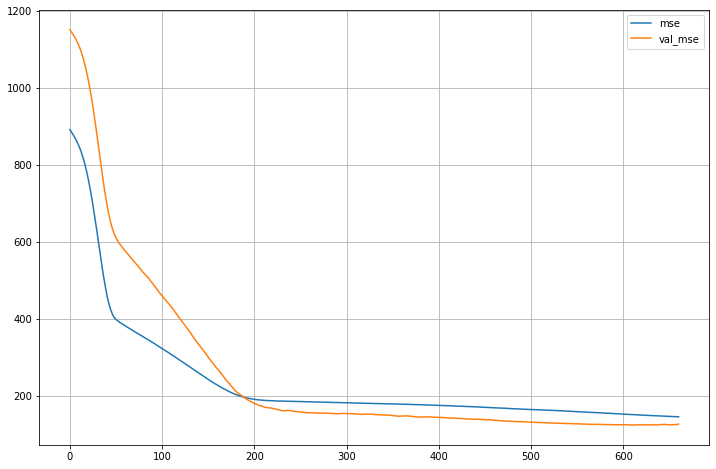

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history["mean_squared_error"])
# 검증 데이터의 mse
plt.plot(history.history["val_mean_squared_error"])
plt.legend(["mse","val_mse"])
plt.grid()
plt.show()

## 8. Keras Regression 함수 만들기

In [50]:
mean_squared_error = []
val_mean_squared_error = []

In [51]:
def kerasRegression(onegroup):
    eachgroup = onegroup.reset_index(drop=True)
    
    corrdf = eachgroup.corr()
    corrStd = 0.5
    features_key = list ( corrdf[ (abs(corrdf["QTY"]) >= corrStd) & (corrdf["QTY"] != 1) ].index)
    label = ["QTY"]
    
    train_dataset = eachgroup[ eachgroup.YEARWEEK < stdYearweek ]
    test_dataset = eachgroup[ eachgroup.YEARWEEK >= stdYearweek ]
    # 답지 별도 분리
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    def norm(x):
        return (x / x.max())
    normed_train_data = norm(train_dataset[features_key])
    normed_test_data = norm(test_dataset[features_key])
    
    from keras import Sequential
    from keras.layers import Dense
    
    def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(features_key)]),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
      ])

      #optimizer = keras.optimizers.RMSprop(0.001)
      optimizer = keras.optimizers.Adam()
      model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_absolute_error', 'mean_squared_error'])
      return model

    model = build_model()
    model.summary()
    
    from keras.callbacks import EarlyStopping
    #더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
    early_stopping_monitor = EarlyStopping(patience=50)
    EPOCHS = 2000
    #모델 훈련 (훈련/검증을 80%, 20%로 나눔)
    history =model.fit(normed_train_data, train_labels, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
    
    mean_squared_error += history.history["mean_squared_error"]
    val_mean_squared_error += history.history["val_mean_squared_error"]
    
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.figure(figsize=(12,8))
    # 훈련 데이터의 mse
    plt.plot(mean_squared_error)
    # 검증 데이터의 mse
    plt.plot(val_mean_squared_error)
    plt.legend(["mse","val_mse"])
    plt.grid()
    return plt.show()

In [52]:
predictResult = sortedData.groupby(groupKey).apply(kerasRegression)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_119 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________
Train on 84 samples, validate on 21 samples
Epoch 1/2000
84/84 [==============================] - 1s 17ms/step - loss: 1278403.7738 - mean_absolute_error: 563.1244 - mean_squared_error: 1278403.7738 - val_loss: 296732.0000 - val_mean_absolute_error: 472.4827 - val_mean_squared_error: 296732.0000
Epoch 2/2000
84/84 [==============================] - 0s 119us/step - loss: 1278317.

84/84 [==============================] - 0s 48us/step - loss: 1233790.1012 - mean_absolute_error: 533.9442 - mean_squared_error: 1233790.1012 - val_loss: 261198.0312 - val_mean_absolute_error: 435.5611 - val_mean_squared_error: 261198.0312
Epoch 63/2000
84/84 [==============================] - 0s 48us/step - loss: 1231358.4048 - mean_absolute_error: 532.3803 - mean_squared_error: 1231358.4048 - val_loss: 259459.8281 - val_mean_absolute_error: 433.6695 - val_mean_squared_error: 259459.8281
Epoch 64/2000
84/84 [==============================] - 0s 71us/step - loss: 1229057.7440 - mean_absolute_error: 530.7774 - mean_squared_error: 1229057.7440 - val_loss: 257647.5469 - val_mean_absolute_error: 431.6887 - val_mean_squared_error: 257647.5469
Epoch 65/2000
84/84 [==============================] - 0s 60us/step - loss: 1226684.6801 - mean_absolute_error: 529.1079 - mean_squared_error: 1226684.6801 - val_loss: 255787.2344 - val_mean_absolute_error: 429.6459 - val_mean_squared_error: 255787.234

84/84 [==============================] - 0s 60us/step - loss: 957123.6905 - mean_absolute_error: 424.4799 - mean_squared_error: 957123.6905 - val_loss: 84258.4609 - val_mean_absolute_error: 193.8167 - val_mean_squared_error: 84258.4609
Epoch 127/2000
84/84 [==============================] - 0s 60us/step - loss: 952829.9851 - mean_absolute_error: 425.6734 - mean_squared_error: 952829.9851 - val_loss: 81916.5391 - val_mean_absolute_error: 190.8992 - val_mean_squared_error: 81916.5391
Epoch 128/2000
84/84 [==============================] - 0s 60us/step - loss: 946390.0714 - mean_absolute_error: 426.3028 - mean_squared_error: 946390.0714 - val_loss: 79773.1953 - val_mean_absolute_error: 188.1189 - val_mean_squared_error: 79773.1953
Epoch 129/2000
84/84 [==============================] - 0s 60us/step - loss: 941871.6443 - mean_absolute_error: 427.3367 - mean_squared_error: 941871.6443 - val_loss: 77609.0078 - val_mean_absolute_error: 185.1908 - val_mean_squared_error: 77609.0078
Epoch 130/2

Epoch 159/2000
84/84 [==============================] - 0s 60us/step - loss: 814943.6488 - mean_absolute_error: 483.1743 - mean_squared_error: 814943.6488 - val_loss: 56877.3438 - val_mean_absolute_error: 205.7698 - val_mean_squared_error: 56877.3438
Epoch 160/2000
84/84 [==============================] - 0s 60us/step - loss: 811690.3185 - mean_absolute_error: 485.3560 - mean_squared_error: 811690.3185 - val_loss: 57661.5938 - val_mean_absolute_error: 209.7356 - val_mean_squared_error: 57661.5938
Epoch 161/2000
84/84 [==============================] - 0s 48us/step - loss: 808249.1726 - mean_absolute_error: 487.3000 - mean_squared_error: 808249.1726 - val_loss: 58486.2148 - val_mean_absolute_error: 213.4713 - val_mean_squared_error: 58486.2148
Epoch 162/2000
84/84 [==============================] - 0s 60us/step - loss: 805341.0833 - mean_absolute_error: 489.3124 - mean_squared_error: 805341.0833 - val_loss: 59401.0078 - val_mean_absolute_error: 217.2277 - val_mean_squared_error: 59401.0

84/84 [==============================] - 0s 60us/step - loss: 1276034.9167 - mean_absolute_error: 561.7633 - mean_squared_error: 1276034.9167 - val_loss: 294840.1562 - val_mean_absolute_error: 470.6183 - val_mean_squared_error: 294840.1562
Epoch 20/2000
84/84 [==============================] - 0s 71us/step - loss: 1275817.3958 - mean_absolute_error: 561.6176 - mean_squared_error: 1275817.3958 - val_loss: 294649.2500 - val_mean_absolute_error: 470.4276 - val_mean_squared_error: 294649.2500
Epoch 21/2000
84/84 [==============================] - 0s 60us/step - loss: 1275570.8214 - mean_absolute_error: 561.4619 - mean_squared_error: 1275570.8214 - val_loss: 294446.2812 - val_mean_absolute_error: 470.2247 - val_mean_squared_error: 294446.2812
Epoch 22/2000
84/84 [==============================] - 0s 71us/step - loss: 1275302.5446 - mean_absolute_error: 561.2951 - mean_squared_error: 1275302.5446 - val_loss: 294228.5312 - val_mean_absolute_error: 470.0068 - val_mean_squared_error: 294228.531

Epoch 83/2000
84/84 [==============================] - 0s 60us/step - loss: 1175259.9405 - mean_absolute_error: 492.9397 - mean_squared_error: 1175259.9405 - val_loss: 217055.2812 - val_mean_absolute_error: 384.5896 - val_mean_squared_error: 217055.2812
Epoch 84/2000
84/84 [==============================] - 0s 71us/step - loss: 1171585.6131 - mean_absolute_error: 490.6204 - mean_squared_error: 1171585.6131 - val_loss: 214449.4688 - val_mean_absolute_error: 381.3782 - val_mean_squared_error: 214449.4688
Epoch 85/2000
84/84 [==============================] - 0s 60us/step - loss: 1168189.7515 - mean_absolute_error: 488.2803 - mean_squared_error: 1168189.7515 - val_loss: 211768.4688 - val_mean_absolute_error: 378.0467 - val_mean_squared_error: 211768.4688
Epoch 86/2000
84/84 [==============================] - 0s 60us/step - loss: 1164330.8631 - mean_absolute_error: 485.7920 - mean_squared_error: 1164330.8631 - val_loss: 209090.1406 - val_mean_absolute_error: 374.6897 - val_mean_squared_err

84/84 [==============================] - 0s 60us/step - loss: 879720.9077 - mean_absolute_error: 448.3101 - mean_squared_error: 879720.9077 - val_loss: 58133.7188 - val_mean_absolute_error: 166.6834 - val_mean_squared_error: 58133.7188
Epoch 148/2000
84/84 [==============================] - 0s 60us/step - loss: 875167.9226 - mean_absolute_error: 449.7130 - mean_squared_error: 875167.9226 - val_loss: 57359.2383 - val_mean_absolute_error: 167.1926 - val_mean_squared_error: 57359.2383
Epoch 149/2000
84/84 [==============================] - 0s 48us/step - loss: 870865.1071 - mean_absolute_error: 451.8863 - mean_squared_error: 870865.1071 - val_loss: 56657.9219 - val_mean_absolute_error: 167.7120 - val_mean_squared_error: 56657.9219
Epoch 150/2000
84/84 [==============================] - 0s 48us/step - loss: 867259.8571 - mean_absolute_error: 454.1684 - mean_squared_error: 867259.8571 - val_loss: 56015.9062 - val_mean_absolute_error: 168.2595 - val_mean_squared_error: 56015.9062
Epoch 151/2

Epoch 180/2000
84/84 [==============================] - 0s 60us/step - loss: 779378.7515 - mean_absolute_error: 513.5734 - mean_squared_error: 779378.7515 - val_loss: 74002.6328 - val_mean_absolute_error: 256.1729 - val_mean_squared_error: 74002.6328
Epoch 181/2000
84/84 [==============================] - 0s 60us/step - loss: 777652.9159 - mean_absolute_error: 515.6576 - mean_squared_error: 777652.9159 - val_loss: 75533.3203 - val_mean_absolute_error: 259.2314 - val_mean_squared_error: 75533.3203
Epoch 182/2000
84/84 [==============================] - 0s 60us/step - loss: 775669.4464 - mean_absolute_error: 517.4613 - mean_squared_error: 775669.4464 - val_loss: 76999.1797 - val_mean_absolute_error: 262.0585 - val_mean_squared_error: 76999.1797
Epoch 183/2000
84/84 [==============================] - 0s 71us/step - loss: 773692.4226 - mean_absolute_error: 518.9915 - mean_squared_error: 773692.4226 - val_loss: 78421.3359 - val_mean_absolute_error: 264.7146 - val_mean_squared_error: 78421.3

84/84 [==============================] - 0s 83us/step - loss: 1271898.4256 - mean_absolute_error: 559.0166 - mean_squared_error: 1271898.4256 - val_loss: 291445.1562 - val_mean_absolute_error: 467.1815 - val_mean_squared_error: 291445.1562
Epoch 36/2000
84/84 [==============================] - 0s 60us/step - loss: 1271386.2143 - mean_absolute_error: 558.6904 - mean_squared_error: 1271386.2143 - val_loss: 291052.8438 - val_mean_absolute_error: 466.7837 - val_mean_squared_error: 291052.8438
Epoch 37/2000
84/84 [==============================] - 0s 60us/step - loss: 1270904.5446 - mean_absolute_error: 558.3578 - mean_squared_error: 1270904.5446 - val_loss: 290630.6562 - val_mean_absolute_error: 466.3551 - val_mean_squared_error: 290630.6562
Epoch 38/2000
84/84 [==============================] - 0s 60us/step - loss: 1270333.2202 - mean_absolute_error: 557.9973 - mean_squared_error: 1270333.2202 - val_loss: 290190.6250 - val_mean_absolute_error: 465.9080 - val_mean_squared_error: 290190.625

84/84 [==============================] - 0s 48us/step - loss: 1146344.1637 - mean_absolute_error: 474.3352 - mean_squared_error: 1146344.1637 - val_loss: 196085.1719 - val_mean_absolute_error: 357.7008 - val_mean_squared_error: 196085.1719
Epoch 100/2000
84/84 [==============================] - 0s 60us/step - loss: 1142374.9107 - mean_absolute_error: 472.0463 - mean_squared_error: 1142374.9107 - val_loss: 193400.5781 - val_mean_absolute_error: 354.1454 - val_mean_squared_error: 193400.5781
Epoch 101/2000
84/84 [==============================] - 0s 48us/step - loss: 1138441.1369 - mean_absolute_error: 469.8176 - mean_squared_error: 1138441.1369 - val_loss: 190700.2344 - val_mean_absolute_error: 350.5341 - val_mean_squared_error: 190700.2344
Epoch 102/2000
84/84 [==============================] - 0s 60us/step - loss: 1134408.1399 - mean_absolute_error: 467.7002 - mean_squared_error: 1134408.1399 - val_loss: 188021.1250 - val_mean_absolute_error: 346.9154 - val_mean_squared_error: 188021.

Epoch 164/2000
84/84 [==============================] - 0s 60us/step - loss: 866996.9226 - mean_absolute_error: 458.3330 - mean_squared_error: 866996.9226 - val_loss: 56015.0820 - val_mean_absolute_error: 169.2357 - val_mean_squared_error: 56015.0820
Epoch 165/2000
84/84 [==============================] - 0s 60us/step - loss: 863713.4673 - mean_absolute_error: 460.1883 - mean_squared_error: 863713.4673 - val_loss: 55592.6953 - val_mean_absolute_error: 169.7061 - val_mean_squared_error: 55592.6953
Epoch 166/2000
84/84 [==============================] - 0s 60us/step - loss: 859519.1161 - mean_absolute_error: 461.6665 - mean_squared_error: 859519.1161 - val_loss: 55259.1484 - val_mean_absolute_error: 170.5318 - val_mean_squared_error: 55259.1484
Epoch 167/2000
84/84 [==============================] - 0s 60us/step - loss: 856222.0595 - mean_absolute_error: 463.6386 - mean_squared_error: 856222.0595 - val_loss: 54980.1914 - val_mean_absolute_error: 172.4499 - val_mean_squared_error: 54980.1

Epoch 197/2000
84/84 [==============================] - 0s 60us/step - loss: 781897.7321 - mean_absolute_error: 516.1204 - mean_squared_error: 781897.7321 - val_loss: 73895.6797 - val_mean_absolute_error: 255.7989 - val_mean_squared_error: 73895.6797
Epoch 198/2000
84/84 [==============================] - 0s 60us/step - loss: 780575.0774 - mean_absolute_error: 517.6929 - mean_squared_error: 780575.0774 - val_loss: 75221.4453 - val_mean_absolute_error: 258.4859 - val_mean_squared_error: 75221.4453
Epoch 199/2000
84/84 [==============================] - 0s 60us/step - loss: 778956.0119 - mean_absolute_error: 519.3849 - mean_squared_error: 778956.0119 - val_loss: 76615.3828 - val_mean_absolute_error: 261.2179 - val_mean_squared_error: 76615.3828
Epoch 200/2000
84/84 [==============================] - 0s 60us/step - loss: 777718.5208 - mean_absolute_error: 521.2182 - mean_squared_error: 777718.5208 - val_loss: 78115.9609 - val_mean_absolute_error: 264.0624 - val_mean_squared_error: 78115.9

84/84 [==============================] - 0s 60us/step - loss: 1270603.9152 - mean_absolute_error: 558.2080 - mean_squared_error: 1270603.9152 - val_loss: 290342.9688 - val_mean_absolute_error: 466.0794 - val_mean_squared_error: 290342.9688
Epoch 39/2000
84/84 [==============================] - 0s 60us/step - loss: 1269953.8899 - mean_absolute_error: 557.8147 - mean_squared_error: 1269953.8899 - val_loss: 289861.8750 - val_mean_absolute_error: 465.5915 - val_mean_squared_error: 289861.8750
Epoch 40/2000
84/84 [==============================] - 0s 48us/step - loss: 1269341.0714 - mean_absolute_error: 557.4089 - mean_squared_error: 1269341.0714 - val_loss: 289353.6562 - val_mean_absolute_error: 465.0753 - val_mean_squared_error: 289353.6562
Epoch 41/2000
84/84 [==============================] - 0s 60us/step - loss: 1268641.3095 - mean_absolute_error: 556.9819 - mean_squared_error: 1268641.3095 - val_loss: 288824.4375 - val_mean_absolute_error: 464.5371 - val_mean_squared_error: 288824.437

84/84 [==============================] - 0s 48us/step - loss: 1128065.0714 - mean_absolute_error: 464.8325 - mean_squared_error: 1128065.0714 - val_loss: 183893.2188 - val_mean_absolute_error: 341.4748 - val_mean_squared_error: 183893.2188
Epoch 103/2000
84/84 [==============================] - 0s 60us/step - loss: 1124151.4167 - mean_absolute_error: 462.5638 - mean_squared_error: 1124151.4167 - val_loss: 181071.0312 - val_mean_absolute_error: 337.5672 - val_mean_squared_error: 181071.0312
Epoch 104/2000
84/84 [==============================] - 0s 60us/step - loss: 1120327.4048 - mean_absolute_error: 460.1358 - mean_squared_error: 1120327.4048 - val_loss: 178191.5000 - val_mean_absolute_error: 333.5352 - val_mean_squared_error: 178191.5000
Epoch 105/2000
84/84 [==============================] - 0s 60us/step - loss: 1115965.6429 - mean_absolute_error: 457.7700 - mean_squared_error: 1115965.6429 - val_loss: 175338.2188 - val_mean_absolute_error: 329.4928 - val_mean_squared_error: 175338.

Epoch 167/2000
84/84 [==============================] - 0s 60us/step - loss: 847542.6845 - mean_absolute_error: 465.7117 - mean_squared_error: 847542.6845 - val_loss: 54372.3086 - val_mean_absolute_error: 177.0479 - val_mean_squared_error: 54372.3086
Epoch 168/2000
84/84 [==============================] - 0s 71us/step - loss: 844416.8869 - mean_absolute_error: 467.7076 - mean_squared_error: 844416.8869 - val_loss: 54311.2812 - val_mean_absolute_error: 179.4714 - val_mean_squared_error: 54311.2812
Epoch 169/2000
84/84 [==============================] - 0s 60us/step - loss: 842050.7262 - mean_absolute_error: 469.8910 - mean_squared_error: 842050.7262 - val_loss: 54331.3398 - val_mean_absolute_error: 182.0388 - val_mean_squared_error: 54331.3398
Epoch 170/2000
84/84 [==============================] - 0s 60us/step - loss: 837818.4821 - mean_absolute_error: 471.7169 - mean_squared_error: 837818.4821 - val_loss: 54421.9297 - val_mean_absolute_error: 184.3600 - val_mean_squared_error: 54421.9

Epoch 200/2000
84/84 [==============================] - 0s 60us/step - loss: 770085.6860 - mean_absolute_error: 523.6338 - mean_squared_error: 770085.6860 - val_loss: 82424.7812 - val_mean_absolute_error: 271.7846 - val_mean_squared_error: 82424.7812
Epoch 201/2000
84/84 [==============================] - 0s 71us/step - loss: 768592.8839 - mean_absolute_error: 525.0187 - mean_squared_error: 768592.8839 - val_loss: 83725.9375 - val_mean_absolute_error: 273.9745 - val_mean_squared_error: 83725.9375
Epoch 202/2000
84/84 [==============================] - 0s 60us/step - loss: 767015.7232 - mean_absolute_error: 526.0388 - mean_squared_error: 767015.7232 - val_loss: 84916.8281 - val_mean_absolute_error: 275.9354 - val_mean_squared_error: 84916.8281
Epoch 203/2000
84/84 [==============================] - 0s 60us/step - loss: 765964.8839 - mean_absolute_error: 527.4302 - mean_squared_error: 765964.8839 - val_loss: 86280.7656 - val_mean_absolute_error: 278.1332 - val_mean_squared_error: 86280.7

UnboundLocalError: local variable 'mean_squared_error' referenced before assignment